# <a id='toc1_'></a>[PRISM Precipitation Gage Data Analysis](#toc0_)

Author: Daniel Hogan

Created: October 17, 2023

This notebook will grab daily precipitation data from a number of different precipitation gages distributed throughout the UCRB to look for and evaluate precipitation changes in these locations between the Baseline and Millennium Drought Periods.

**Table of contents**<a id='toc0_'></a>    
- [PRISM Precipitation Gage Data Analysis](#toc1_)    
    - [Imports](#toc1_1_1_)    
- [Grab station data and calculate seasonal and annual precipitation totals](#toc2_)    
    - [Get seasonal precipitation totals at each station](#toc2_1_1_)    
    - [Get station location information for each station used](#toc2_1_2_)    
    - [Separate into seasonal precipitation totals](#toc2_1_3_)    
    - [Calculate annual precipitation totals](#toc2_1_4_)    
- [Change in station precipitation between periods](#toc3_)    
    - [Annual Change](#toc3_1_1_)    
    - [Spring Change](#toc3_1_2_)    
    - [Summer Change](#toc3_1_3_)    
    - [Winter Change](#toc3_1_4_)    
    - [Fall Change](#toc3_1_5_)    
    - [Station Locations](#toc3_1_6_)    
    - [Save precipitation change results](#toc3_1_7_)    
- [Plot Annual and Seasonal Changes at Precipitation Gages](#toc4_)    
    - [Annual Change](#toc4_1_1_)    
    - [Spring Change](#toc4_1_2_)    
    - [Summer Change](#toc4_1_3_)    
    - [Winter Change](#toc4_1_4_)    
    - [Fall Change](#toc4_1_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_1_'></a>[Imports](#toc0_)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as stats
import geopandas as gpd
import contextily as ctx

# <a id='toc2_'></a>[Grab station data and calculate seasonal and annual precipitation totals](#toc0_)
Stations were downloaded from the [NOAA Climate Data Online Portal](https://www.ncei.noaa.gov/cdo-web/)

In [2]:
# load in station_observations_UCRB.csv
station_observations = pd.read_csv('../data/precipdata/daily_ucrb_station_data.csv')
station_observations_filter = station_observations.set_index('DATE')[['STATION','NAME','PRCP', 'LONGITUDE', 'LATITUDE', 'ELEVATION']]
# convert LONGITUDE, LATITUDE, and ELEVATION to string
station_observations_filter['LONGITUDE'] = station_observations_filter['LONGITUDE'].astype(str)
station_observations_filter['LATITUDE'] = station_observations_filter['LATITUDE'].astype(str)
station_observations_filter['ELEVATION'] = station_observations_filter['ELEVATION'].astype(str)

# convert index to a datetime
station_observations_filter.index = pd.to_datetime(station_observations_filter.index, format='%m/%d/%Y')

# filter out data if PRCP is < 0 or greater than 250
station_observations_filter = station_observations_filter[(station_observations_filter['PRCP'] >= 0) & (station_observations_filter['PRCP'] <= 250)]

### <a id='toc2_1_1_'></a>[Get seasonal precipitation totals at each station](#toc0_)

In [3]:
# create a function to group PRCP by the seasonal sum
def seasonal_sum(df):
    return df['PRCP'].groupby(pd.Grouper(freq='QS-DEC')).sum()

seasonal_sum_df = station_observations_filter.groupby('STATION').apply(seasonal_sum).T
# remove data where the STATION is USC00055484
# seasonal_sum_df = seasonal_sum_df.drop('USC00055484', axis=0)
# set DATE to a datetime and make it the index
seasonal_sum_df.index = pd.to_datetime(seasonal_sum_df.index, format='%m/%d/%Y')
# add a column for water year (Oct - Sept) for each row 
seasonal_sum_df['WY'] = seasonal_sum_df.index.year.where(seasonal_sum_df.index.month < 10, seasonal_sum_df.index.year + 1)



### <a id='toc2_1_2_'></a>[Get station location information for each station used](#toc0_)

In [4]:
station_df = station_observations[['STATION','NAME','LATITUDE','LONGITUDE','ELEVATION']].drop_duplicates()
station_df = station_df.set_index('STATION')
# filter to the unique station numbers in seasonal_sum_df
stations_used_df = station_df.loc[list(seasonal_sum_df.columns)[:-1]]
stations_used_df.to_csv('../data/precipdata/stations_used.csv')

### <a id='toc2_1_3_'></a>[Separate into seasonal precipitation totals](#toc0_)

In [5]:
# separate the data into seasonal dataframes for winter, spring, summer, and fall
winter_df = seasonal_sum_df[seasonal_sum_df.index.month.isin([12])].drop('WY', axis=1)
spring_df = seasonal_sum_df[seasonal_sum_df.index.month.isin([3])].drop('WY', axis=1)
summer_df = seasonal_sum_df[seasonal_sum_df.index.month.isin([6])].drop('WY', axis=1)
fall_df = seasonal_sum_df[seasonal_sum_df.index.month.isin([9])].drop('WY', axis=1)

# filter these new dataframes to values greater than 0 and less than 400, if zero fill with nan
filter_winter_df = winter_df.where((winter_df > 10) & (winter_df < 400), np.nan)
filter_spring_df = spring_df.where((spring_df > 10) & (spring_df < 400), np.nan)
filter_summer_df = summer_df.where((summer_df > 10) & (summer_df < 400), np.nan)
filter_fall_df = fall_df.where((fall_df > 10) & (fall_df < 400), np.nan)

# Add a water year column to each dataframe
filter_winter_df['WY'] = filter_winter_df.index.year.where(filter_winter_df.index.month < 10, filter_winter_df.index.year + 1)
filter_spring_df['WY'] = filter_spring_df.index.year.where(filter_spring_df.index.month < 10, filter_spring_df.index.year + 1)
filter_summer_df['WY'] = filter_summer_df.index.year.where(filter_summer_df.index.month < 10, filter_summer_df.index.year + 1)
filter_fall_df['WY'] = filter_fall_df.index.year.where(filter_fall_df.index.month < 10, filter_fall_df.index.year + 1)

# make WY the index
filter_winter_df.set_index('WY', inplace=True)
filter_spring_df.set_index('WY', inplace=True)
filter_summer_df.set_index('WY', inplace=True)
filter_fall_df.set_index('WY', inplace=True)

### <a id='toc2_1_4_'></a>[Calculate annual precipitation totals](#toc0_)

In [6]:
# calculate the sum for each WY for each station
annual_sum_df = seasonal_sum_df.groupby(['WY']).sum()
annual_sum_df.reset_index(inplace=True)
# make WY the new index
annual_sum_df.set_index('WY', inplace=True)
# replace values equal to 0 with nan
annual_sum_df = annual_sum_df.where(annual_sum_df > 100, np.nan)


# <a id='toc3_'></a>[Change in station precipitation between periods](#toc0_)

In [7]:
# create a hypothesis test to see if pre-2000 and post-2000 are PRCP values for spring df are different
# create a function to perform the hypothesis test
def hypothesis_test(df, year, alternative='greater'):
    # create a dataframe for pre-2000 and post-2000
    pre_2000 = df.loc[:year-1]
    if len(pre_2000) < 20:
        return np.nan
    post_2000 = df.loc[year:]
    # perform a t-test on the two dataframes
    t_test = stats.ttest_ind(np.log(pre_2000), np.log(post_2000), equal_var=True, alternative=alternative, nan_policy='omit')
    # return the p-value
    return t_test.pvalue

# create a function to calculate the percent difference in mean values between the two periods
def percent_difference(df, year):
    # create a dataframe for pre-2000 and post-2000
    pre_2000 = df.loc[:year-1]
    if len(pre_2000) < 20:
        return np.nan
    post_2000 = df.loc[year:]
    # calculate the mean for each period
    pre_2000_mean = pre_2000.mean()
    post_2000_mean = post_2000.mean()
    # calculate the percent difference
    percent_diff = (post_2000_mean - pre_2000_mean) / pre_2000_mean * 100
    # return the percent difference
    return percent_diff

### <a id='toc3_1_1_'></a>[Annual Change](#toc0_)

In [8]:
# iterate through the independent sites and run the hypothesis test with year = 2000
annual_significant_change = {}
annual_no_significant_change = {}
for station in annual_sum_df.columns:
    result = hypothesis_test(annual_sum_df[station], 2000, alternative='greater')
    pct_diff = percent_difference(annual_sum_df[station], 2000)
    if result <= 0.05:
        print(station, '|', round(result,3), '|', 'Significant Difference', '|', round(pct_diff,2), '%')
        annual_significant_change[station] = pct_diff

    else:
        print(station, '|', round(result,3), '|', 'No Significant Difference', '|', round(pct_diff,2), '%')
        annual_no_significant_change[station] = pct_diff
    print('------------------')

USC00051959 | 0.159 | No Significant Difference | -6.56 %
------------------
USC00053662 | 0.005 | Significant Difference | -17.85 %
------------------
USC00055484 | 0.003 | Significant Difference | -21.1 %
------------------
USC00056832 | 0.275 | No Significant Difference | -5.76 %
------------------
USC00057618 | 0.0 | Significant Difference | -41.64 %
------------------
USC00057656 | 0.506 | No Significant Difference | -3.85 %
------------------
USC00057936 | 0.125 | No Significant Difference | -5.45 %
------------------
USC00058064 | 0.053 | No Significant Difference | -11.0 %
------------------
USC00058184 | 0.018 | Significant Difference | -10.36 %
------------------
USC00058204 | 0.0 | Significant Difference | -23.54 %
------------------
USC00058501 | 0.218 | No Significant Difference | -3.88 %
------------------
USC00058582 | 0.005 | Significant Difference | -13.2 %
------------------
USC00059175 | 0.009 | Significant Difference | -9.71 %
------------------
USC00059265 | 0.634 

### <a id='toc3_1_2_'></a>[Spring Change](#toc0_)

In [9]:
# iterate through the independent sites and run the hypothesis test with year = 2000
spring_significant_change = {}
spring_no_significant_change = {}
for station in filter_spring_df.columns:
    result = hypothesis_test(filter_spring_df[station], 2000, alternative='greater')
    pct_diff = percent_difference(filter_spring_df[station], 2000)
    if result < 0.07:
        print(station, '|', round(result,3), '|', 'Significant Difference', '|', round(pct_diff,2), '%')
        spring_significant_change[station] = pct_diff
    else:
        print(station, '|', round(result,3), '|', 'No Significant Difference', '|', round(pct_diff,2), '%')
        spring_no_significant_change[station] = pct_diff
    print('------------------')

USC00051959 | 0.065 | Significant Difference | -13.87 %
------------------
USC00053662 | 0.072 | No Significant Difference | -16.53 %
------------------
USC00055484 | 0.063 | Significant Difference | -19.02 %
------------------
USC00056832 | 0.061 | Significant Difference | -16.37 %
------------------
USC00057618 | 0.0 | Significant Difference | -47.8 %
------------------
USC00057656 | 0.127 | No Significant Difference | -12.78 %
------------------
USC00057936 | 0.038 | Significant Difference | -10.77 %
------------------
USC00058064 | 0.317 | No Significant Difference | -0.76 %
------------------
USC00058184 | 0.01 | Significant Difference | -17.96 %
------------------
USC00058204 | 0.0 | Significant Difference | -34.25 %
------------------
USC00058501 | 0.219 | No Significant Difference | -9.78 %
------------------
USC00058582 | 0.019 | Significant Difference | -25.68 %
------------------
USC00059175 | 0.058 | Significant Difference | -9.8 %
------------------
USC00059265 | 0.899 | N

### <a id='toc3_1_3_'></a>[Summer Change](#toc0_)

In [10]:
# iterate through the independent sites and run the hypothesis test with year = 2000
summer_significant_change = {}
summer_no_significant_change = {}
for station in filter_summer_df.columns:
    result = hypothesis_test(filter_summer_df[station], 2000, alternative='greater')
    pct_diff = percent_difference(filter_summer_df[station], 2000)
    if result < 0.07:
        print(station, '|', round(result,3), '|', 'Significant Difference', '|', round(pct_diff,2), '%')
        summer_significant_change[station] = pct_diff
    else:
        print(station, '|', round(result,3), '|', 'No Significant Difference', '|', round(pct_diff,2), '%')
        summer_no_significant_change[station] = pct_diff
    print('------------------')

USC00051959 | 0.257 | No Significant Difference | -5.95 %
------------------
USC00053662 | 0.002 | Significant Difference | -32.13 %
------------------
USC00055484 | 0.001 | Significant Difference | -37.78 %
------------------
USC00056832 | 0.069 | Significant Difference | -19.62 %
------------------
USC00057618 | 0.0 | Significant Difference | -43.59 %
------------------
USC00057656 | 0.026 | Significant Difference | -21.0 %
------------------
USC00057936 | 0.402 | No Significant Difference | -1.17 %
------------------
USC00058064 | 0.301 | No Significant Difference | -7.18 %
------------------
USC00058184 | 0.868 | No Significant Difference | 7.24 %
------------------
USC00058204 | 0.091 | No Significant Difference | -14.96 %
------------------
USC00058501 | 0.61 | No Significant Difference | 4.94 %
------------------
USC00058582 | 0.18 | No Significant Difference | -11.34 %
------------------
USC00059175 | 0.02 | Significant Difference | -18.24 %
------------------
USC00059265 | 0.0

### <a id='toc3_1_4_'></a>[Winter Change](#toc0_)

In [11]:
# iterate through the independent sites and run the hypothesis test with year = 2000
winter_significant_change = {}
winter_no_significant_change = {}
for station in filter_winter_df.columns:
    result = hypothesis_test(filter_winter_df[station], 2000, alternative='greater')
    pct_diff = percent_difference(filter_winter_df[station], 2000)
    if result < 0.07:
        print(station, '|', round(result,3), '|', 'Significant Difference', '|', round(pct_diff,2), '%')
        winter_significant_change[station] = pct_diff
    else:
        print(station, '|', round(result,3), '|', 'No Significant Difference', '|', round(pct_diff,2), '%')
        winter_no_significant_change[station] = pct_diff
    print('------------------')

USC00051959 | 0.509 | No Significant Difference | -3.39 %
------------------
USC00053662 | 0.173 | No Significant Difference | -7.62 %
------------------
USC00055484 | 0.156 | No Significant Difference | -15.29 %
------------------
USC00056832 | 0.976 | No Significant Difference | 25.28 %
------------------
USC00057618 | 0.0 | Significant Difference | -38.45 %
------------------
USC00057656 | 0.995 | No Significant Difference | 29.97 %
------------------
USC00057936 | 0.075 | No Significant Difference | -15.54 %
------------------
USC00058064 | 0.061 | Significant Difference | -16.85 %
------------------
USC00058184 | 0.118 | No Significant Difference | -13.4 %
------------------
USC00058204 | 0.017 | Significant Difference | -19.97 %
------------------
USC00058501 | 0.26 | No Significant Difference | -6.84 %
------------------
USC00058582 | 0.284 | No Significant Difference | -4.79 %
------------------
USC00059175 | 0.525 | No Significant Difference | -1.34 %
------------------
USC000

### <a id='toc3_1_5_'></a>[Fall Change](#toc0_)

In [12]:
# iterate through the independent sites and run the hypothesis test with year = 2000
fall_significant_change = {}
fall_no_significant_change = {}
for station in filter_fall_df.columns:
    result = hypothesis_test(filter_fall_df[station], 2000, alternative='greater')
    pct_diff = percent_difference(filter_fall_df[station], 2000)
    if result < 0.07:
        print(station, '|', round(result,3), '|', 'Significant Difference', '|', round(pct_diff,2), '%')
        fall_significant_change[station] = pct_diff
    else:
        print(station, '|', round(result,3), '|', 'No Significant Difference', '|', round(pct_diff,2), '%')
        fall_no_significant_change[station] = pct_diff
    print('------------------')

USC00051959 | 0.06 | Significant Difference | -13.82 %
------------------
USC00053662 | 0.078 | No Significant Difference | -16.68 %
------------------
USC00055484 | 0.339 | No Significant Difference | -9.65 %
------------------
USC00056832 | 0.487 | No Significant Difference | -4.28 %
------------------
USC00057618 | 0.004 | Significant Difference | -28.28 %
------------------
USC00057656 | 0.451 | No Significant Difference | -4.48 %
------------------
USC00057936 | 0.593 | No Significant Difference | 3.94 %
------------------
USC00058064 | 0.001 | Significant Difference | -24.47 %
------------------
USC00058184 | 0.294 | No Significant Difference | -4.03 %
------------------
USC00058204 | 0.026 | Significant Difference | -22.17 %
------------------
USC00058501 | 0.184 | No Significant Difference | -7.23 %
------------------
USC00058582 | 0.157 | No Significant Difference | -10.09 %
------------------
USC00059175 | 0.084 | No Significant Difference | -9.85 %
------------------
USC0005

### <a id='toc3_1_6_'></a>[Station Locations](#toc0_)

In [13]:
station_locs = station_observations_filter.drop_duplicates(subset='STATION')
# create a geodataframe of the station locations
station_locations = gpd.GeoDataFrame(station_locs, geometry=gpd.points_from_xy(station_locs['LONGITUDE'].astype(float), station_locs['LATITUDE'].astype(float)))
# set the coordinate reference system to WGS84
station_locations.crs = 'EPSG:4326'
# convert the coordinate reference system to UTM Zone 13N
station_locations = station_locations.to_crs('EPSG:32613')

ucrb_boundary = gpd.read_file('../basin_characteristics/Upper_Colorado_River_Basin_Boundary.json')
# convert ucrb_boundary to UTM Zone 13N
ucrb_boundary = ucrb_boundary.to_crs('EPSG:32613')

# filter to only include locations inside the ucrb_boundary
station_locations = gpd.sjoin(station_locations, ucrb_boundary, how='inner', predicate='intersects')


### <a id='toc3_1_7_'></a>[Save precipitation change results](#toc0_)

In [14]:
pd.Series(annual_significant_change).to_csv('../data/precipdata/station_changes_by_season/annual_significant_change.csv')
pd.Series(annual_no_significant_change).to_csv('../data/precipdata/station_changes_by_season/annual_no_significant_change.csv')
# do the same for the seasonal changes
pd.Series(spring_significant_change).to_csv('../data/precipdata/station_changes_by_season/spring_significant_change.csv')
pd.Series(spring_no_significant_change).to_csv('../data/precipdata/station_changes_by_season/spring_no_significant_change.csv')
pd.Series(summer_significant_change).to_csv('../data/precipdata/station_changes_by_season/summer_significant_change.csv')
pd.Series(summer_no_significant_change).to_csv('../data/precipdata/station_changes_by_season/summer_no_significant_change.csv')
pd.Series(fall_significant_change).to_csv('../data/precipdata/station_changes_by_season/fall_significant_change.csv')
pd.Series(fall_no_significant_change).to_csv('../data/precipdata/station_changes_by_season/fall_no_significant_change.csv')
pd.Series(winter_significant_change).to_csv('../data/precipdata/station_changes_by_season/winter_significant_change.csv')
pd.Series(winter_no_significant_change).to_csv('../data/precipdata/station_changes_by_season/winter_no_significant_change.csv')

station_locations.to_file('../data/geodata/prcp_stations.json', driver='GeoJSON')

# <a id='toc4_'></a>[Plot Annual and Seasonal Changes at Precipitation Gages](#toc0_)

### <a id='toc4_1_1_'></a>[Annual Change](#toc0_)

Text(0.5, 1.0, 'Annual Precipitation Change in the UCRB')

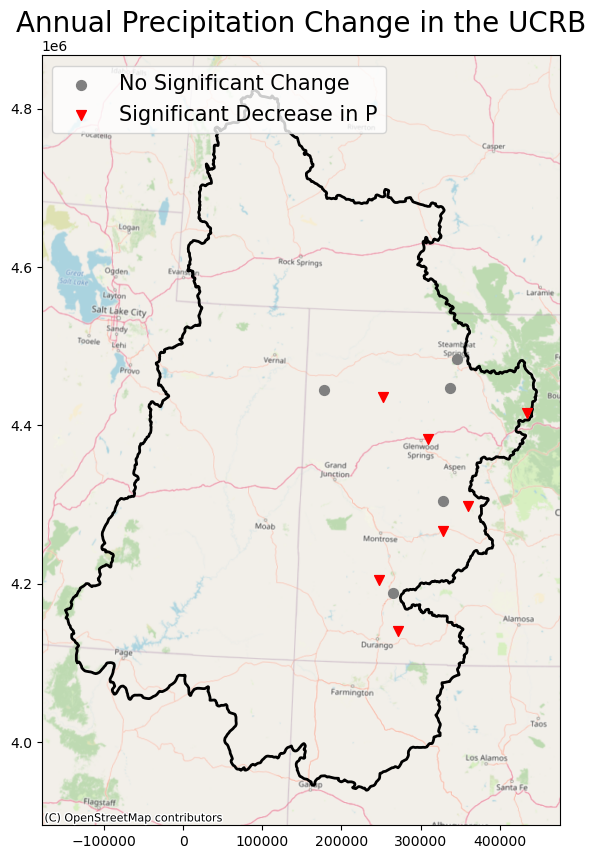

In [15]:
# plot the station locations on a map with the basemap being the UCRB boundary
fig, ax = plt.subplots(figsize=(15,10))

ucrb_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=2)
# plot station not included in annual_significant change with  marker size scaled by annual_significant_change value

station_locations[station_locations['STATION'].isin(annual_no_significant_change.keys())].plot(ax=ax, color='gray', markersize=50)
# plot station locations included in annual_significant_change with a downward red triangle
station_locations[station_locations['STATION'].isin(annual_significant_change.keys())].plot(ax=ax, color='red', markersize=50, marker='v')
# add a basemap with the US states with Stamen Toner Topography

ctx.add_basemap(ax, crs='EPSG:32613', source=ctx.providers.OpenStreetMap.Mapnik)

# add a legend for the station locations saying down arrow means significant decrease and circle means no significant change
ax.legend(['No Significant Change', 'Significant Decrease in P'], loc='upper left', fontsize=15)
ax.set_title('Annual Precipitation Change in the UCRB', fontsize=20)

### <a id='toc4_1_2_'></a>[Spring Change](#toc0_)

Text(0.5, 1.0, 'Spring Precipitation Change in the UCRB')

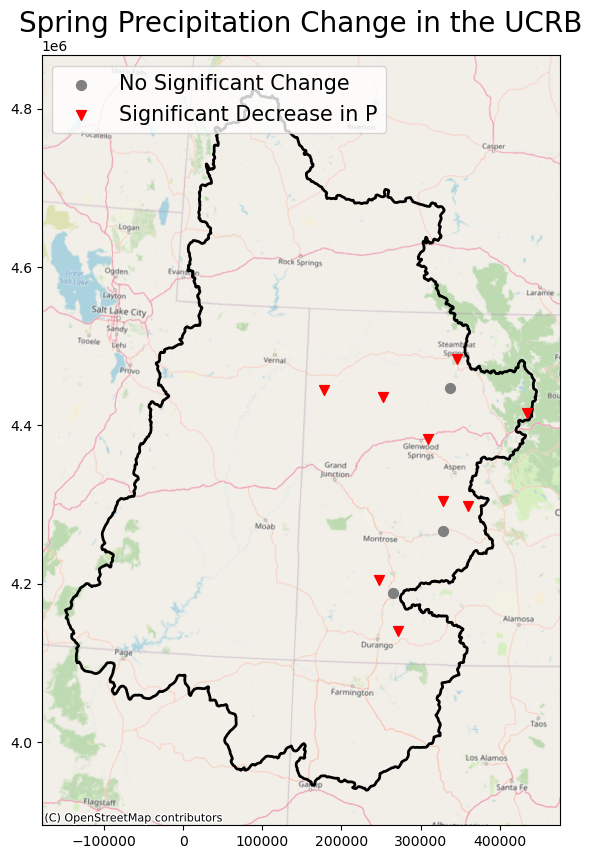

In [16]:

# plot the station locations on a map with the basemap being the UCRB boundary
fig, ax = plt.subplots(figsize=(15,10))

ucrb_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=2)
# plot station not included in spring_significant change with  with a large circle
station_locations[station_locations['STATION'].isin(spring_no_significant_change.keys())].plot(ax=ax, color='gray', markersize=50)
# plot station locations included in spring_significant_change with a downward red triangle
station_locations[station_locations['STATION'].isin(spring_significant_change.keys())].plot(ax=ax, color='red', markersize=50, marker='v')
# add text to each point showing the percent difference
# for station in spring_significant_change.keys():
#     ax.text(station_locations[station_locations['STATION'] == station]['geometry'].x, station_locations[station_locations['STATION'] == station]['geometry'].y, str(round(spring_significant_change[station],0)) + '%', fontsize=15)
# add a basemap with the US states with Stamen Toner Topography
ctx.add_basemap(ax, crs='EPSG:32613', source=ctx.providers.OpenStreetMap.Mapnik)
# add a legend for the station locations saying down arrow means significant decrease and circle means no significant change
ax.legend(['No Significant Change', 'Significant Decrease in P'], loc='upper left', fontsize=15)
ax.set_title('Spring Precipitation Change in the UCRB', fontsize=20)

### <a id='toc4_1_3_'></a>[Summer Change](#toc0_)

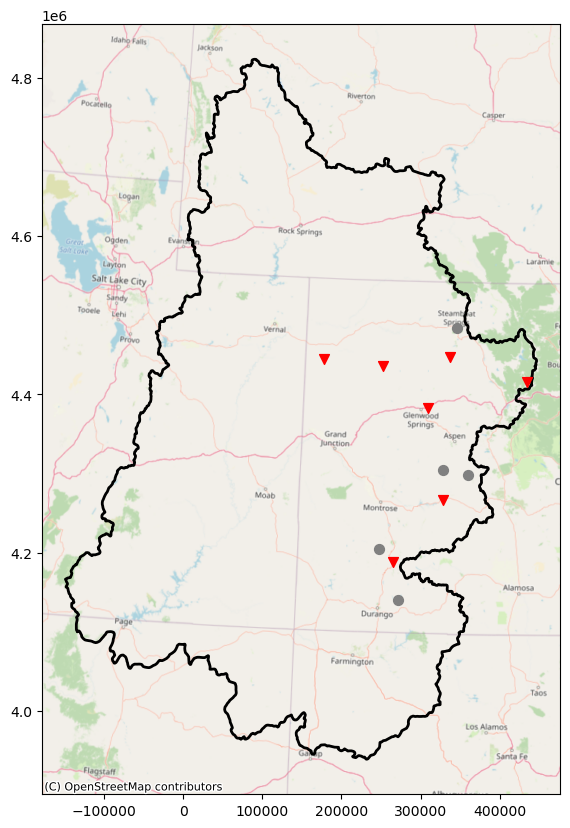

In [17]:

# plot the station locations on a map with the basemap being the UCRB boundary
fig, ax = plt.subplots(figsize=(15,10))

ucrb_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=2)
# plot station not included in spring_significant change with  with a large circle
station_locations[~station_locations['STATION'].isin(summer_significant_change)].plot(ax=ax, color='gray', markersize=50)
# plot station locations included in spring_significant_change with a downward red triangle
station_locations[station_locations['STATION'].isin(summer_significant_change)].plot(ax=ax, color='red', markersize=50, marker='v')
# add a basemap with the US states
ctx.add_basemap(ax, crs='EPSG:32613', source=ctx.providers.OpenStreetMap.Mapnik)

### <a id='toc4_1_4_'></a>[Winter Change](#toc0_)

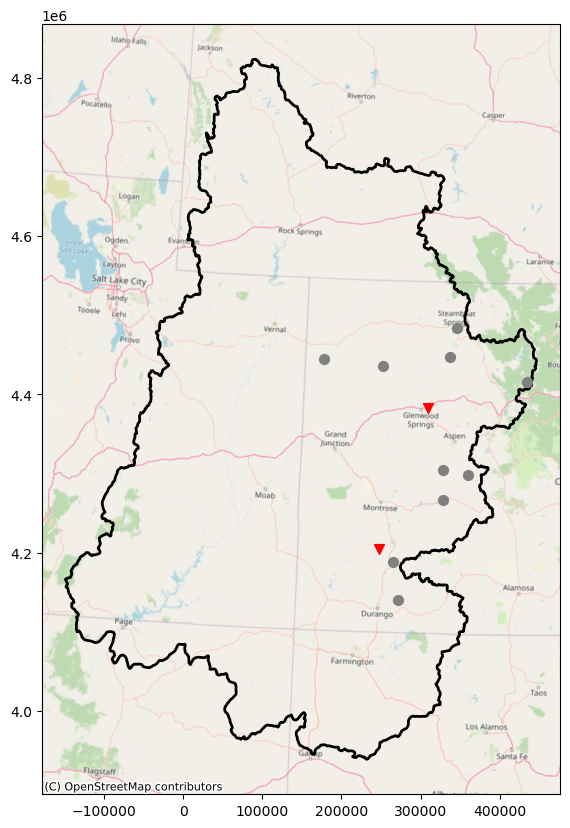

In [18]:

# plot the station locations on a map with the basemap being the UCRB boundary
fig, ax = plt.subplots(figsize=(15,10))

ucrb_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=2)
# plot station not included in winter_significant change with  with a large circle
station_locations[~station_locations['STATION'].isin(winter_significant_change)].plot(ax=ax, color='gray', markersize=50)
# plot station locations included in winter_significant_change with a downward red triangle
station_locations[station_locations['STATION'].isin(winter_significant_change)].plot(ax=ax, color='red', markersize=50, marker='v')
# add a basemap with the US states with Stamen Toner Topography

ctx.add_basemap(ax, crs='EPSG:32613', source=ctx.providers.OpenStreetMap.Mapnik)

### <a id='toc4_1_5_'></a>[Fall Change](#toc0_)

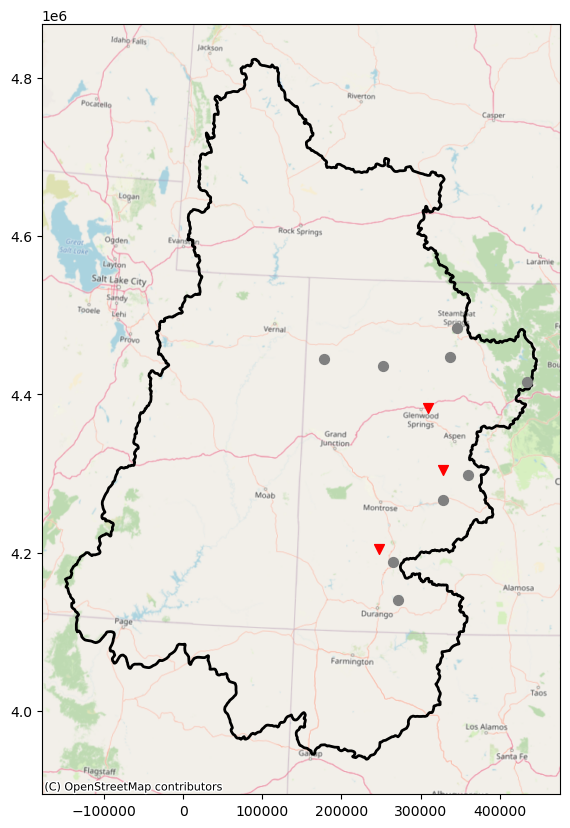

In [19]:

# plot the station locations on a map with the basemap being the UCRB boundary
fig, ax = plt.subplots(figsize=(15,10))

ucrb_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=2)
# plot station not included in fall_significant change with  with a large circle
station_locations[~station_locations['STATION'].isin(fall_significant_change)].plot(ax=ax, color='gray', markersize=50)
# plot station locations included in fall_significant_change with a downward red triangle
station_locations[station_locations['STATION'].isin(fall_significant_change)].plot(ax=ax, color='red', markersize=50, marker='v')
# add a basemap with the US states with Stamen Toner Topography

ctx.add_basemap(ax, crs='EPSG:32613', source=ctx.providers.OpenStreetMap.Mapnik)